# MLR model construction

## Data loading and data analysis

In [1]:
# import some packages
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
# read in the data
data = pd.read_csv('ps_usable_hydrogen_storage_capacity_gcmcv2.csv')

## Information about the data
This dataset contains 98,694 different MOFs with 7 structural properties and usable gravimetric storage capacity (UG) and usable volumetric storage capacity (UV) to measure the hydrogen storage capacity of each MOF. 

7 Structural properties,  2 responses and their units of this dataset are provided as follows:

Property | unit
--- | ---
Density | $$g/cm^3$$
Gravimetric surface area (GSA) | $$m^2/g$$
Volumetric surface area (VSA) | $$m^2/cm^3$$
Void fracion (VF)| 
Pore volumn (PV)| $$cm^3/g$$
Largest cavity diameter (LCD) | $$Å$$
Pore limiting diameter (PLD) | $$Å$$
Usable gravimetric storage capacity (UG) | $$wt.\%$$
Usable volumetric storage capacity (UV) | $$g/cm^3$$

## Data cleaning

In [3]:
# check the size of the loaded data 
assert(data.shape[0] == 98694)
assert(data.shape[1] == 17)

### 1. Column name modifications

In [4]:
data = data.rename(columns=lambda x: x.rstrip()) # delete the extra space in the end and check it again
data = data.rename(columns={'UG at PS':'UG', 'UV at PS': 'UV'}) # simplify some columns' names

### 2. Abnormal data removal

In [5]:
# remove data whose features are smaller or equal to 0
features_name = data.columns[5:12].tolist()
for feature in features_name:
    data = data.drop(data[data[feature] <= 0].index)

## Check missing values

In [6]:
def check_nan(col, data):
    '''Count the number of nan for a specific column in a dataset.'''
    return data.shape[0] - data[col].dropna().size

def print_nan(features):
    '''Print nan for original_training_data'''
    for feature in features:
        print('  Nan of ' + str(feature) + ': ' + str(check_nan(feature, data)))

print_nan(features_name)

  Nan of Density: 0
  Nan of GSA: 0
  Nan of VSA: 0
  Nan of VF: 0
  Nan of PV: 0
  Nan of LCD: 0
  Nan of PLD: 0


Comparing the cleaned dataset and the original one, one can found that there are some abnormal data in this dataset. The structures with features that are smaller or equal to 0 can be due to some possible mistakes when collecting the data and are impossible to shown outstanding hydrogen adsorption performance according to the discovered relationships between these features and adsorption capacity. However, there is no missing value for the 7 features and the 2 responses. 

# Visulization of the dataset

## Distributions of single features and UG/UV

In [7]:
def plot_dist(data, var_names):
    '''Plot the distribution of each variable.'''
    for var in var_names:
        plt.figure(figsize=(20, 6))
        sns.histplot(data[var], kde = True)
        plt.xlabel(var, fontsize = 15)
        plt.ylabel('Count', fontsize = 15)
        
features_name.append('UG')
features_name.append('UV')
#plot_dist(data, features_name)

From the above visulizations, one can observe that the distributions of different features and responses are extremely different. Some of them are right skewed while others are left skewed. Also, they have different ranges.

## Relationship between UV and UG

(-8.0, 55.0)

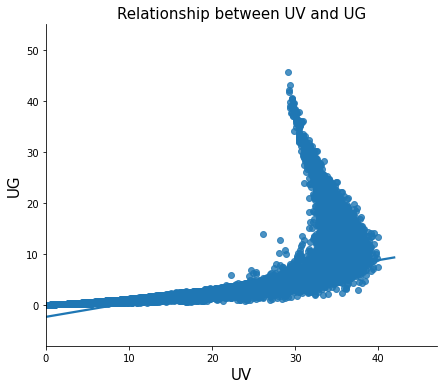

In [8]:
sns.lmplot(x = 'UV', y = 'UG', data = data, aspect = 1.2, truncate = False)
plt.title('Relationship between UV and UG', fontsize = 15)
plt.xlabel('UV', fontsize = 15)
plt.xlim(0, 47)
plt.ylabel('UG', fontsize = 15)
plt.ylim(-8, 55)

In [9]:
r1 = np.corrcoef(data['UV'],data['UG'])[0][1]
r1

0.761160782050035

From the above figure, one can see that the linear correlation between the two reponses is not as high as expected. Points with relatively high UG and low UV occur in the dataset. Intuitively, this is related to the low density of these structures. The below visulization proves this assumption.

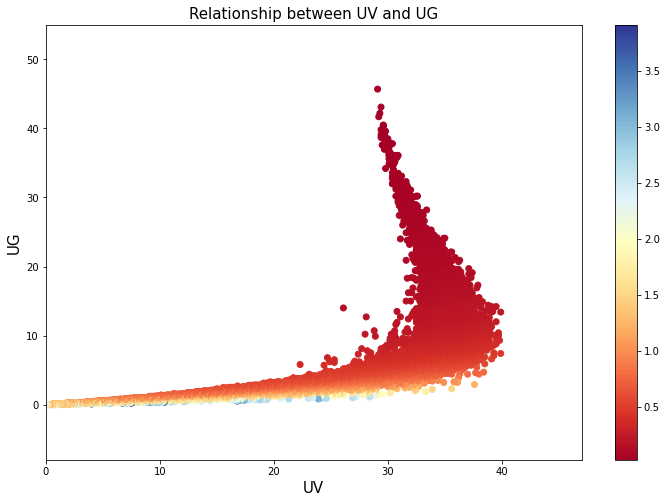

In [10]:
cm = plt.cm.get_cmap('RdYlBu')
plt.figure(figsize=(12, 8))
plt.scatter(data['UV'], data['UG'], c = data['Density'], cmap = cm)
plt.title('Relationship between UV and UG', fontsize = 15)
plt.xlabel('UV', fontsize = 15)
plt.xlim(0, 47)
plt.ylabel('UG', fontsize = 15)
plt.ylim(-8, 55)
plt.colorbar()

## Relationship between each structural property and UG/UV

In [11]:
def single_feature_plot(data, single_feature):
    '''Plot the relationship between single feature and UG/UV'''
    
    # check that the input single_feature has type of str
    try:
        assert(type(single_feature) == str)
    except:
        raise TypeError('The input single_feature is not string.')

    if single_feature == 'Density':
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 6))
        ax1.scatter(data[single_feature], data['UG'])
        ax1.set_xlabel(single_feature, fontsize = 15)
        ax1.set_ylabel('UG',fontsize = 15)
        ax1.set_title('Relationship between '+single_feature+ ' and UG', fontsize = 15)
        ax2.scatter(data[single_feature], data['UV'])
        ax2.set_xlabel(single_feature, fontsize = 15)
        ax2.set_ylabel('UV', fontsize = 15)
        ax2.set_title('Relationship between '+single_feature+ ' and UV', fontsize = 15)
    else:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 5))
        sc1 = ax1.scatter(data[single_feature], data['UG'], c = data['Density'], cmap = cm)
        ax1.set_xlabel(single_feature, fontsize = 15)
        ax1.set_ylabel('UG',fontsize = 15)
        ax1.set_title('Relationship between '+single_feature+ ' and UG', fontsize = 15)
        fig.colorbar(sc1, ax = ax1)
        sc2 = ax2.scatter(data[single_feature], data['UV'], c = data['Density'], cmap = cm)
        ax2.set_xlabel(single_feature, fontsize = 15)
        ax2.set_ylabel('UV', fontsize = 15)
        ax2.set_title('Relationship between '+single_feature+ ' and UV', fontsize = 15)
        fig.colorbar(sc2, ax = ax2)

#for single_feature in features_name[:7]:
#    single_feature_plot(data, single_feature)

## Identify the importance of each feature

In [12]:
# calculating the correlation coefficient
corr_coefs = []
for single_feature in features_name[:7]:
    corr_coefs.append([np.corrcoef(data[single_feature],data['UV'])[0][1],np.corrcoef(data[single_feature],data['UG'])[0][1]])

df_rs = pd.DataFrame(columns =['UV', 'UG'], data = corr_coefs, index = features_name[:7])
df_rs['Avg_corr'] = (df_rs['UV'] + df_rs['UG'])/2
df_rs

,UV,UG,Avg_corr
Density,-0.859508,-0.766090,-0.812799
GSA,0.879863,0.832255,0.856059
VSA,0.532700,0.083976,0.308338
VF,0.931162,0.792888,0.862025
PV,0.531987,0.933700,0.732844
LCD,0.598503,0.828389,0.713446
PLD,0.616799,0.826018,0.721409


According to the above analysis, density is negatively correlated with UG/UV while other features are positively correlated with UG/UV. However, the linear correlation between the features (except density) and responses are not strong. This can be due to the differences of density. 

In [13]:
df_rs_abs = df_rs.copy()
df_rs_abs = abs(df_rs_abs) # consider the feature importance as its absolute value
df_rs_abs_1 = df_rs_abs.sort_values(by = 'Avg_corr', ascending = False)
df_rs_abs_2 = df_rs_abs.sort_values(by = 'UV', ascending = False)
df_rs_abs_3 = df_rs_abs.sort_values(by = 'UG', ascending = False)
print('Features ranking:')
print('   UV + UG: ')
print('   '+str(df_rs_abs_1.index.tolist()))
print('   UV: ')
print('   '+str(df_rs_abs_2.index.tolist()))
print('   UG: ')
print('   '+str(df_rs_abs_3.index.tolist()))

Features ranking:
   UV + UG: 
   ['VF', 'GSA', 'Density', 'PV', 'PLD', 'LCD', 'VSA']
   UV: 
   ['VF', 'GSA', 'Density', 'PLD', 'LCD', 'VSA', 'PV']
   UG: 
   ['PV', 'GSA', 'LCD', 'PLD', 'VF', 'Density', 'VSA']


From the above analysis, we can found that the VF has the biggest influence on the overall hydrogen adsorption performance while the VSA has the smallest influence on the overall hydrogen adsorption performance. In terms of UV, the most important factor is VF and the least important is VSA. For UG, the most important factor is PV and the least important one is VSA.

# Data transformation
Data transformation can be hard because it requires to achieve linear relationships between each features and two responses simultaneously. Herein, I try my best to do the data transformation to achieve this by tring both logrithm transformation and power transformation of different values. Only the best results were left in this part.

In [14]:
# create an empty list to store the transformed average correlation coefficients
transformed_avg_corrs = []

# Density
data_trans = data.copy()
data_trans['Density'] = -np.log(data_trans['Density'])
val1 = sum([np.corrcoef(data_trans['Density'],data['UV'])[0][1],np.corrcoef(data_trans['Density'],data['UG'])[0][1]])/2
transformed_avg_corrs.append(val1)

# GSA
data_trans['GSA'] = data_trans['GSA']**1.1
val2 = sum([np.corrcoef(data_trans['GSA'],data['UV'])[0][1],np.corrcoef(data_trans['GSA'],data['UG'])[0][1]])/2
transformed_avg_corrs.append(val2)

# VSA
data_trans['VSA'] = (data_trans['VSA'])**0.2
val3 = sum([np.corrcoef(data_trans['VSA'],data['UV'])[0][1],np.corrcoef(data_trans['VSA'],data['UG'])[0][1]])/2
transformed_avg_corrs.append(val3)

# VF
data_trans['VF'] = (data_trans['VF'])**4.2
val4 = sum([np.corrcoef(data_trans['VF'],data['UV'])[0][1],np.corrcoef(data_trans['VF'],data['UG'])[0][1]])/2
transformed_avg_corrs.append(val4)

# PV
data_trans['PV'] = (data_trans['PV'])**0.1
val5 = sum([np.corrcoef(data_trans['PV'],data['UV'])[0][1],np.corrcoef(data_trans['PV'],data['UG'])[0][1]])/2
transformed_avg_corrs.append(val5)

# LCD
data_trans['LCD'] = np.log(data_trans['LCD'])
val6 = sum([np.corrcoef(data_trans['LCD'],data['UV'])[0][1],np.corrcoef(data_trans['LCD'],data['UG'])[0][1]])/2
transformed_avg_corrs.append(val6)

# PLD
data_trans['PLD'] = np.log(data_trans['PLD'])
val7 = sum([np.corrcoef(data_trans['PLD'],data['UV'])[0][1],np.corrcoef(data_trans['PLD'],data['UG'])[0][1]])/2
transformed_avg_corrs.append(val7)

In [15]:
df_rs['Transformed_avg_corr'] = transformed_avg_corrs
df_rs

,UV,UG,Avg_corr,Transformed_avg_corr
Density,-0.859508,-0.766090,-0.812799,0.888286
GSA,0.879863,0.832255,0.856059,0.856803
VSA,0.532700,0.083976,0.308338,0.321852
VF,0.931162,0.792888,0.862025,0.920270
PV,0.531987,0.933700,0.732844,0.903927
LCD,0.598503,0.828389,0.713446,0.755663
PLD,0.616799,0.826018,0.721409,0.801401


In [16]:
df_rs_trans_sort = df_rs.sort_values(by = 'Transformed_avg_corr', ascending = False)
print('Features ranking:')
print('   UV + UG -- transformed: ')
print('   '+str(df_rs_trans_sort.index.tolist()))

Features ranking:
   UV + UG -- transformed: 
   ['VF', 'PV', 'Density', 'GSA', 'PLD', 'LCD', 'VSA']


Transform all the features to have better linear relationship to the 2 responses may lead to higher accuracy of the multi-linear regression model. But whether this assumption is true still requires further modeling work.

# Linear Regression Models

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression as lr
from sklearn.metrics import mean_squared_error
from sklearn.multioutput import MultiOutputRegressor as mor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score

features_name = data.columns[5:12].tolist()

### Steps for MLR
Step 1. Tunning the features (done!): 
* Data transformation or not (done!) -- no data transformation
* Number of features (done!) -- 7

Step 2. Regularization methods (done!) -- Ridge

Step 3. Optimal train/test ratio (done!) -- train_size = 0.9

Step 4. Cross validation hyperparameters (done!) -- fold_number = 9 

## Step 1. Tunning the features

In [18]:
# Pipeline for tunning the features
def func_certain_features(features, data):
    
    train, test = train_test_split(data, train_size = 0.9, random_state=42)
    model = mor(lr()).fit(train[features], train[['UV','UG']])
    
    r2_train = model.score(train[features], train[['UV','UG']])
    r2_test = model.score(test[features], test[['UV','UG']])
    
    rmse_train = mean_squared_error(train[['UV','UG']], model.predict(train[features]), squared = False)
    rmse_test = mean_squared_error(test[['UV','UG']], model.predict(test[features]), squared = False)
    
    return [r2_train, r2_test, rmse_train, rmse_test]
    
def feature_tun(df_sort, data):
    features = df_sort.index.tolist()
    
    r2s_train = []
    r2s_test = []
    rmses_train = []
    rmses_test = []
    
    for i in range(1, len(features)+1):
        r2_train, r2_test, rmse_train, rmse_test = func_certain_features(features[:i], data)
        #print(features[:i])
        
        r2s_train.append(r2_train)
        r2s_test.append(r2_test)
        rmses_train.append(rmse_train)
        rmses_test.append(rmse_test)
    
    return [r2s_train, r2s_test, rmses_train, rmses_test]

### Basic linear model without data transformation

In [19]:
r2s_train, r2s_test, rmses_train, rmses_test = feature_tun(df_rs_abs_1, data)
r2s_test

[0.7502577892839093,
 0.7940389779999042,
 0.7943843065104641,
 0.9230437378091145,
 0.9288577158950734,
 0.9398897597500188,
 0.9500846700392334]

### Basic linear models with data transformation

In [20]:
r2s_train_trans, r2s_test_trans, rmses_train_trans, rmses_test_trans = feature_tun(df_rs_trans_sort, data_trans)
r2s_test_trans

[0.8472564825859483,
 0.8651361888390601,
 0.8822313866751184,
 0.8964820634047764,
 0.8994167970424745,
 0.9057534097194689,
 0.9413078662426215]

Text(0.5, 1.0, 'R2 score')

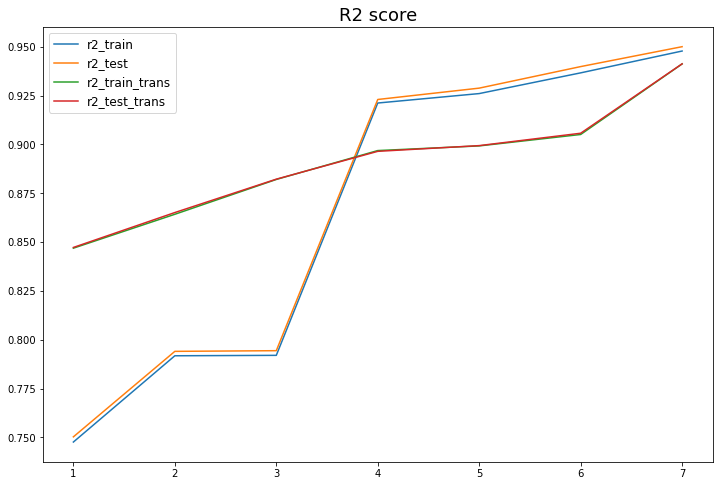

In [21]:
plt.figure(figsize = (12, 8))
plt.plot(np.linspace(1, 7, 7), r2s_train)
plt.plot(np.linspace(1, 7, 7), r2s_test)
plt.plot(np.linspace(1, 7, 7), r2s_train_trans)
plt.plot(np.linspace(1, 7, 7), r2s_test_trans)
plt.legend(['r2_train', 'r2_test', 'r2_train_trans', 'r2_test_trans'], fontsize = 12)
plt.title('R2 score', fontsize = 18)

Text(0.5, 1.0, 'RMSE')

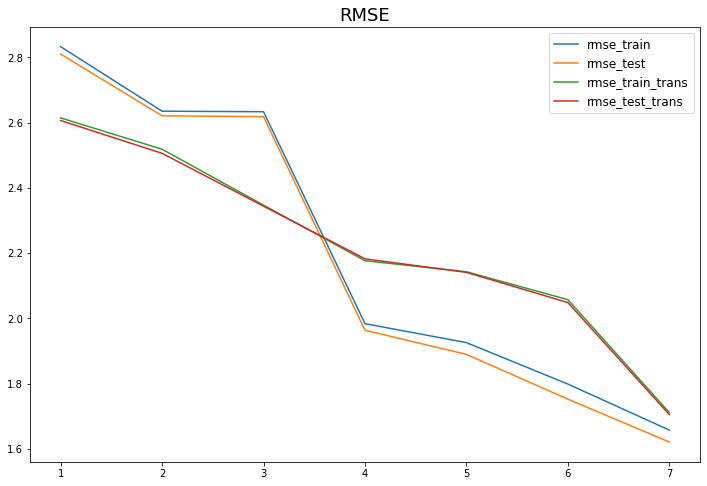

In [22]:
plt.figure(figsize = (12, 8))
plt.plot(np.linspace(1, 7, 7), rmses_train)
plt.plot(np.linspace(1, 7, 7), rmses_test)
plt.plot(np.linspace(1, 7, 7), rmses_train_trans)
plt.plot(np.linspace(1, 7, 7), rmses_test_trans)
plt.legend(['rmse_train', 'rmse_test', 'rmse_train_trans', 'rmse_test_trans'], fontsize = 12)
plt.title('RMSE', fontsize = 18)

### Conclusion: 
* Data transformation doesn't lead to better results for linear models. 
* 7 features should be all included.


## Step 2. Regularization method

In [23]:
features_name

['Density', 'GSA', 'VSA', 'VF', 'PV', 'LCD', 'PLD']

In [24]:
def reg_method(data, method):
    train, test = train_test_split(data, train_size = 0.9, random_state=42)
    model = mor(method).fit(train[features_name], train[['UV','UG']])

    r2_train = model.score(train[features_name], train[['UV','UG']])
    r2_test = model.score(test[features_name], test[['UV','UG']])

    rmse_train = mean_squared_error(train[['UV','UG']], model.predict(train[features_name]), squared = False)
    rmse_test = mean_squared_error(test[['UV','UG']], model.predict(test[features_name]), squared = False)

    print([r2_train, r2_test, rmse_train, rmse_test])
    
    return [r2_train, r2_test, rmse_train, rmse_test]

### 1. Linear Regression model

In [25]:
reg_method(data, lr())

[0.9478622668250045, 0.9500846700392329, 1.6573822561707767, 1.6208541762783422]


[0.9478622668250045,
 0.9500846700392329,
 1.6573822561707767,
 1.6208541762783422]

### 2. Ridge

In [26]:
reg_method(data, Ridge())

[0.9478595297107677, 0.9500858389397866, 1.6574257887394663, 1.6208357802062943]


[0.9478595297107677,
 0.9500858389397866,
 1.6574257887394663,
 1.6208357802062943]

### 3. LASSO

In [27]:
reg_method(data, Lasso())

[0.8827617380715354, 0.884316176351946, 2.4526749374529673, 2.432737853202511]


[0.8827617380715354, 0.884316176351946, 2.4526749374529673, 2.432737853202511]

### Conclusion:
Considering the performance on the test set: Ridge is the best. Lasso is worst. Select Ridge. 

## Step 3. Determine the optimal train_test_ratio

In [99]:
train_test_ratios = np.linspace(0.1, 0.9, 9)

r2_trains = []
r2_tests = []
rmse_trains = []
rmse_tests = []

for ratio in train_test_ratios:
    train, test = train_test_split(data, train_size = ratio, random_state=42)
    model = mor(Ridge()).fit(train[features_name], train[['UV','UG']])
    
    r2_trains.append(model.score(train[features_name], train[['UV','UG']]))
    r2_tests.append(model.score(test[features_name], test[['UV','UG']]))

    RMSE_train = mean_squared_error(train[['UV','UG']], model.predict(train[features_name]), squared = False)
    rmse_trains.append(RMSE_train)
    RMSE_test = mean_squared_error(test[['UV','UG']], model.predict(test[features_name]), squared = False)
    rmse_tests.append(RMSE_test)

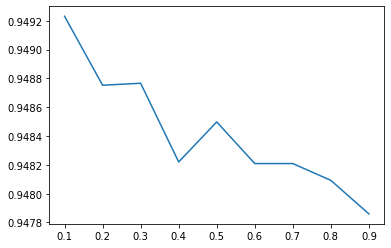

In [100]:
plt.plot(train_test_ratios, r2_trains)

In [101]:
r2_tests

[0.9477194690053818,
 0.9477008692554312,
 0.947714593501822,
 0.947932692207528,
 0.9475827705839377,
 0.9478252933607738,
 0.9477403681697011,
 0.9480255834129019,
 0.9500858389397866]

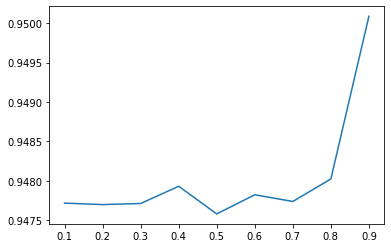

In [30]:
plt.plot(train_test_ratios, r2_tests)

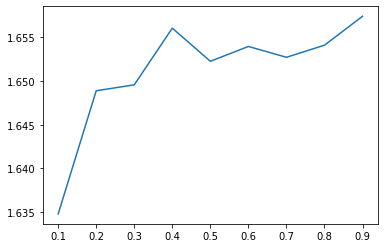

In [31]:
plt.plot(train_test_ratios, rmse_trains)

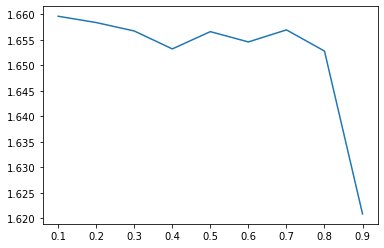

In [32]:
plt.plot(train_test_ratios, rmse_tests)

### Conclusion:
Optimal value of train_size = 0.9 considering the generalization ability of the model.

## Step 4. Cross Validation or not

### Models with validation

In [107]:
def cv_data(array):
    #array_fold = array_ratio.copy()
    
    for i in range(len(array)):
        array[i] = np.mean(array[i])
    
    index = array.index(max(array))
            
    return [index+2, max(array), array]

In [108]:
from sklearn.model_selection import KFold

fold_number = np.linspace(2, 10, 9)

def CV(method):
    
    r2_trains = [] 
    r2_vals = [] 
    r2_tests = [] 

    for fold in fold_number:
        trains_fold= []
        vals_fold = []
        tests_fold = []

        kf = KFold(n_splits=int(fold), shuffle = True)

        for train_index, test_index in kf.split(data):
            X_train, X_val = data.iloc[train_index], data.iloc[test_index]
            y_train, y_val = data.iloc[train_index], data.iloc[test_index]

            model = mor(method).fit(X_train[features_name], y_train[['UV','UG']])

        trains_fold.append(cross_val_score(model, X_train[features_name], y_train[['UV','UG']], cv = kf))
        vals_fold.append(cross_val_score(model, X_val[features_name], y_val[['UV','UG']], cv = kf))
        tests_fold.append(cross_val_score(model, test[features_name], test[['UV','UG']], cv = kf))

        r2_trains.append(trains_fold)
        r2_vals.append(vals_fold)
        r2_tests.append(tests_fold)
        
    return [r2_trains, r2_vals, r2_tests]

### LR

In [113]:
lr_score = []
lr_index = []
for i in range(11):
    _, _, r2_tests_lr = CV(lr())
    opt_index, max_arr, array = cv_data(r2_tests_lr)
    lr_index.append(opt_index)
    lr_score.append(max_arr)
print(lr_score)
print(lr_index)

[0.9504986487659498, 0.9501560848918226, 0.9502052430642646, 0.9501505091734314, 0.9503521709897693, 0.9503369197046976, 0.9502180246868789, 0.9501563111970415, 0.950091454807138, 0.950008730468825, 0.9500655338880316]
[2, 5, 3, 7, 5, 2, 3, 2, 9, 8, 9]


### Ridge

In [114]:
r_score = []
r_index = []
for i in range(11):
    _, _, r2_tests_ridge = CV(Ridge())
    opt_index, max_arr, array = cv_data(r2_tests_ridge)
    r_index.append(opt_index)
    r_score.append(max_arr)
print(r_score)
print(r_index)

[0.9498251202771856, 0.9498426071454452, 0.9497582578950917, 0.9497926637594439, 0.9497905948002835, 0.9498377649204941, 0.9498300226159963, 0.9498791525499783, 0.9499004962495012, 0.9498301866164611, 0.9498173832988674]
[3, 6, 9, 5, 6, 9, 6, 4, 10, 4, 7]


### LASSO

In [115]:
l_score = []
l_index = []
for i in range(11):
    _, _, r2_tests_l = CV(Lasso())
    opt_index, max_arr, array = cv_data(r2_tests_l)
    l_index.append(opt_index)
    l_score.append(max_arr)
print(l_score)
print(l_index)

[0.8859214053780203, 0.886118366732536, 0.8863296135487233, 0.8858936839373962, 0.8867093234157539, 0.8857513231873995, 0.8857191944423217, 0.8856418112035396, 0.8862939530809362, 0.8855410434599446, 0.8863722527640983]
[3, 3, 3, 3, 2, 2, 2, 3, 2, 3, 2]


### Conclusion:
No optimal fold number. Random sampling can leads to random optimal fold number.

# Conclusion of MLR

* Some models has r2 score higher than 0.95 on test set:
1. train_size = 0.9, LR + CV.
1. train_size = 0.9, Ridge
* The ceiling of r2 score on test set of this dataset using MLR is about 0.95.
* Ridge + CV starts to behave a little bit overfitting as its r2 score on test set is lower than pure Ridge.